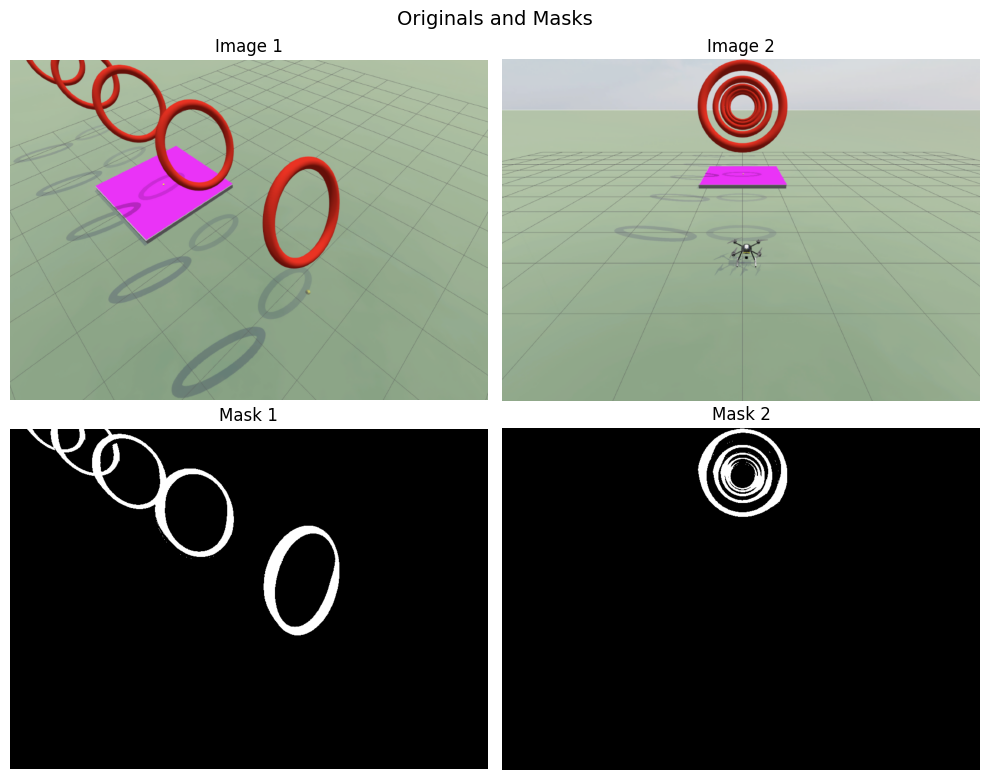

In [1]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def color_mask_from_rgb(pil_image, rgb_color, tol=5):
    """
    Build a binary mask of pixels within ±tol of the given RGB color.
    Returns a uint8 mask: 255 for in-range pixels, 0 otherwise.
    """
    img_rgb = pil_image.convert("RGB")
    arr_rgb = np.asarray(img_rgb, dtype=np.uint8)

    r, g, b = rgb_color
    lower = np.array([max(0, r - tol), max(0, g - tol), max(0, b - tol)], dtype=np.uint8)
    upper = np.array([min(255, r + tol), min(255, g + tol), min(255, b + tol)], dtype=np.uint8)

    mask = cv2.inRange(arr_rgb, lower, upper)
    return mask

# Inputs
hoopCol = (236, 2, 1)
tolerance = 100
testImgs = [Image.open("img1.png"), Image.open("img2.png")]

# Compute masks
masks = [color_mask_from_rgb(img, hoopCol, tol=tolerance) for img in testImgs]

# 2x2 grid: originals (top), masks (bottom)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows x 2 cols
fig.suptitle("Originals and Masks", fontsize=14)

# Row 1: original images
axs[0, 0].imshow(testImgs[0])
axs[0, 0].set_title("Image 1")
axs[0, 0].axis("off")

axs[0, 1].imshow(testImgs[1])
axs[0, 1].set_title("Image 2")
axs[0, 1].axis("off")

# Row 2: masks (grayscale, 0..255)
axs[1, 0].imshow(masks[0], cmap="gray", vmin=0, vmax=255)
axs[1, 0].set_title("Mask 1")
axs[1, 0].axis("off")

axs[1, 1].imshow(masks[1], cmap="gray", vmin=0, vmax=255)
axs[1, 1].set_title("Mask 2")
axs[1, 1].axis("off")

fig.tight_layout()
plt.show()


In [2]:
# Step 0: Imports and helpers
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import random

plt.rcParams['figure.figsize'] = (10, 8)

# Utility: show multiple images in a grid
def show_grid(images, titles=None, ncols=2, cmap=None):
    n = len(images)
    nrows = int(np.ceil(n / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axs = np.array(axs).reshape(nrows, ncols)
    for i in range(nrows*ncols):
        ax = axs[i // ncols, i % ncols]
        if i < n:
            im = images[i]
            if im.ndim == 2:
                ax.imshow(im, cmap=cmap or 'gray', vmin=0, vmax=255 if im.dtype==np.uint8 else None)
            else:
                # assume RGB
                ax.imshow(im)
            if titles:
                ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Convert PIL Image (RGB) to OpenCV BGR
def pil_to_bgr(pil_img):
    arr = np.array(pil_img.convert('RGB'))
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

# Convert BGR to RGB for plotting
def bgr_to_rgb(arr_bgr):
    return cv2.cvtColor(arr_bgr, cv2.COLOR_BGR2RGB)

# Draw an OpenCV ellipse tuple on an image (RGB)
def draw_ellipse_rgb(img_rgb, ellipse, color=(0,255,0), thickness=2):
    bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR).copy()
    cv2.ellipse(bgr, ellipse, color, thickness)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# Build conic matrix of a 2D ellipse from fitEllipse params (center, axes, angle in degrees)
def ellipse_conic_matrix(center, axes, angle_deg):
    cx, cy = center
    a = axes[0] / 2.0
    b = axes[1] / 2.0
    theta = np.deg2rad(angle_deg)
    # Rotation
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    # Canonical ellipse: x'^2/a^2 + y'^2/b^2 = 1 -> Q' = diag(1/a^2, 1/b^2)
    Qp = np.diag([1.0/(a*a), 1.0/(b*b)])
    # Transform to image coordinates: (x - c)^T R Q' R^T (x - c) = 1
    Q = R @ Qp @ R.T
    # Expand to homogeneous conic: [x y 1] C [x y 1]^T = 0, where
    # [A B/2; B/2 C] = Q, and linear term from -2Q c, and constant c^T Q c - 1
    A = Q[0,0]; B = 2*Q[0,1]; Cc = Q[1,1]
    d = -2*(Q @ np.array([cx, cy]))
    D, E = d[0], d[1]
    F = (np.array([cx, cy]) @ Q @ np.array([cx, cy])) - 1.0
    # Conic matrix
    C = np.array([[A, B/2, D/2],
                  [B/2, Cc, E/2],
                  [D/2, E/2, F]], dtype=np.float64)
    return C

# Estimate intrinsics from image width and assumed horizontal FOV (degrees)
def estimate_K_from_fov(img_w, img_h, hfov_deg=78.0):
    hfov = math.radians(hfov_deg)
    fx = (img_w / 2.0) / math.tan(hfov / 2.0)
    fy = fx  # assume square pixels
    cx, cy = img_w / 2.0, img_h / 2.0
    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0,  0,  1]], dtype=np.float64)
    return K

# Identity quaternion (w,x,y,z) -> rotation matrix (for completeness)
def quat_to_R(qw, qx, qy, qz):
    n = math.sqrt(qw*qw + qx*qx + qy*qy + qz*qz)
    if n == 0: 
        return np.eye(3)
    qw, qx, qy, qz = qw/n, qx/n, qy/n, qz/n
    R = np.array([
        [1-2*(qy*qy+qz*qz), 2*(qx*qy - qz*qw), 2*(qx*qz+qy*qw)],
        [2*(qx*qy+qz*qw), 1-2*(qx*qx+qz*qz), 2*(qy*qz - qx*qw)],
        [2*(qx*qz - qy*qw), 2*(qy*qz + qx*qw), 1-2*(qx*qx+qy*qy)]
    ], dtype=np.float64)
    return R

# Distance estimate from ellipse semi-major and known radius using nominal fx
def estimate_distance_from_ellipse(a_px, radius_ft, fx_px):
    # z ≈ f * r / a  (approximate for modest tilts)
    if a_px <= 1:
        return None
    z_ft = (fx_px * radius_ft) / a_px
    return z_ft


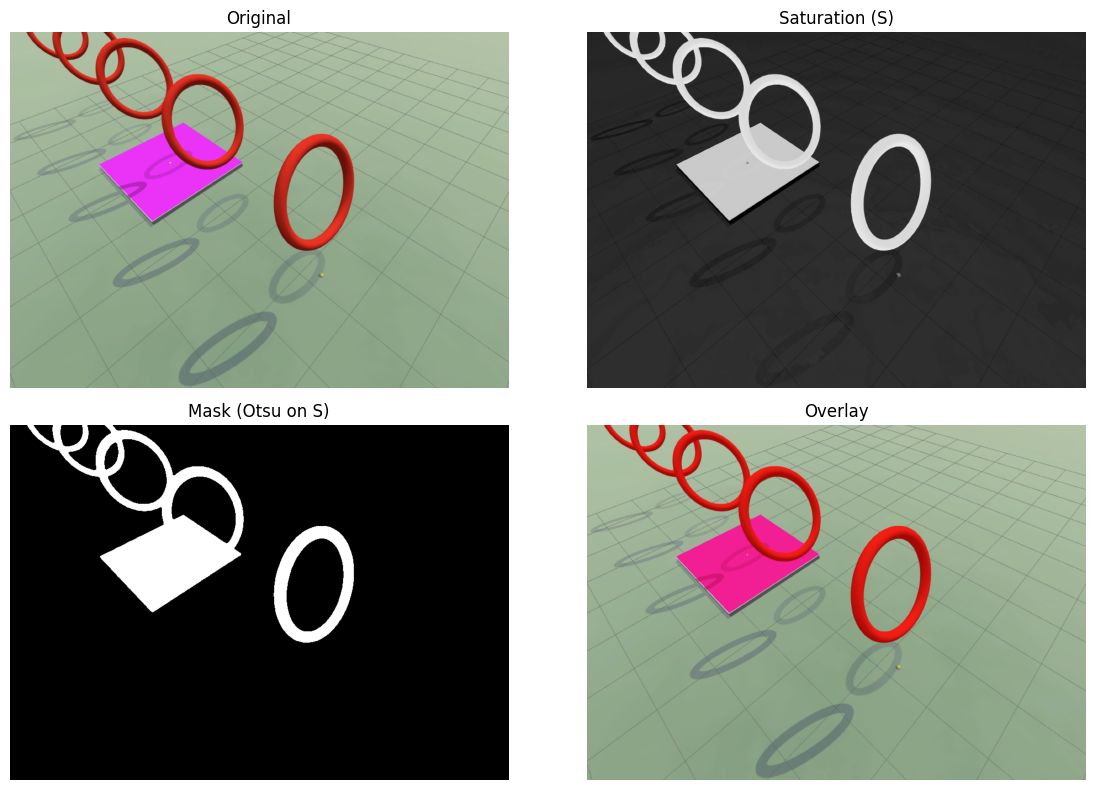

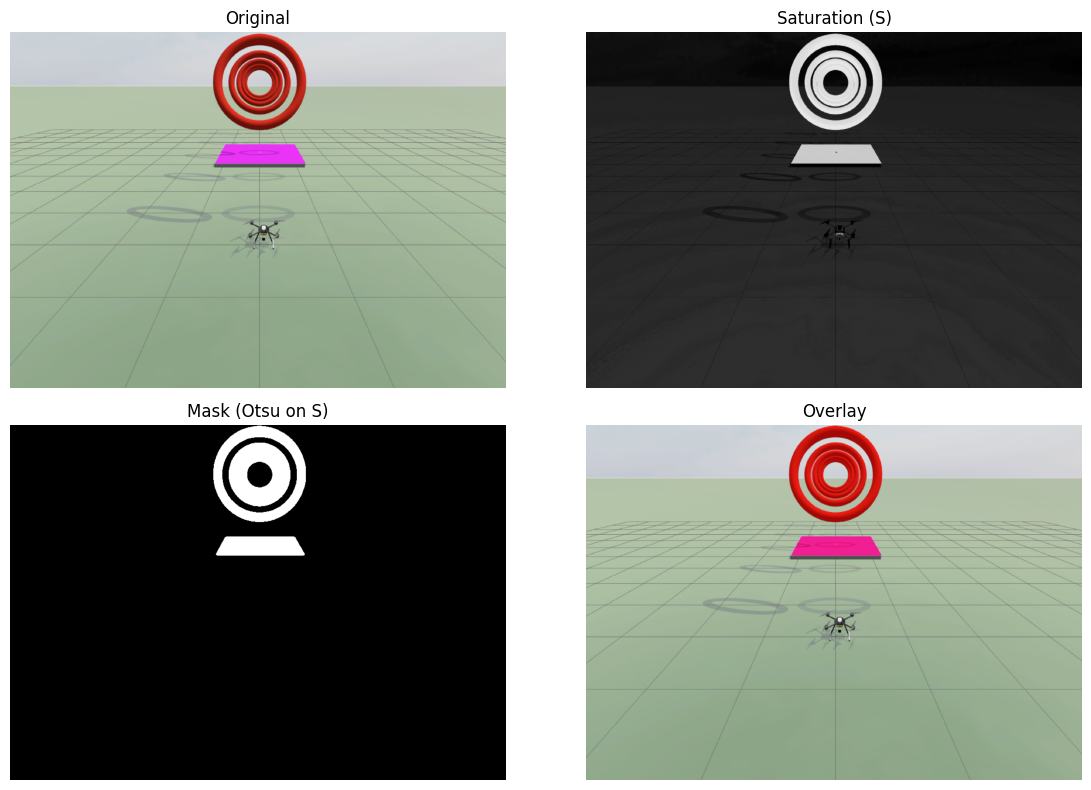

In [3]:
# Step 1 (replaced): Minimal saturation-only mask that remains compatible with your next cell

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

def show_grid(images, titles=None, ncols=2, cmap=None):
    n = len(images)
    nrows = int(np.ceil(n / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axs = np.array(axs).reshape(nrows, ncols)
    for i in range(nrows*ncols):
        ax = axs[i // ncols, i % ncols]
        if i < n:
            im = images[i]
            if im.ndim == 2:
                ax.imshow(im, cmap=cmap or 'gray', vmin=0, vmax=255 if im.dtype==np.uint8 else None)
            else:
                ax.imshow(im)
            if titles:
                ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def pil_to_bgr(pil_img):
    arr = np.array(pil_img.convert('RGB'))
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)

def bgr_to_rgb(arr_bgr):
    return cv2.cvtColor(arr_bgr, cv2.COLOR_BGR2RGB)

# Inputs
testImgs = [Image.open("img1.png"), Image.open("img2.png")]

all_step1_debug = []

for idx, pil_img in enumerate(testImgs):
    # Convert to HSV and extract S
    bgr = pil_to_bgr(pil_img)
    rgb = bgr_to_rgb(bgr)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    S = hsv[:, :, 1]

    # Otsu threshold on S (high saturation -> hoop)
    # If hoops appear dark in S due to material/lighting, flip to THRESH_BINARY_INV
    _, mask = cv2.threshold(S, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Small morphology to fill small gaps and remove specks
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k, iterations=1)

    mask_refined = mask  # keep name for compatibility with your next cell

    # Debug overlay
    overlay = rgb.copy()
    overlay[mask_refined > 0] = (0.6*overlay[mask_refined > 0] + 0.4*np.array([255, 0, 0])).astype(np.uint8)

    # Save exactly what the next cell needs
    all_step1_debug.append({
        'rgb': rgb,
        's': S,                 # for visualization only
        'mask_refined': mask_refined
    })

    # Display core steps
    show_grid(
        [rgb, S, mask_refined, overlay],
        titles=["Original", "Saturation (S)", "Mask (Otsu on S)", "Overlay"],
        ncols=2
    )


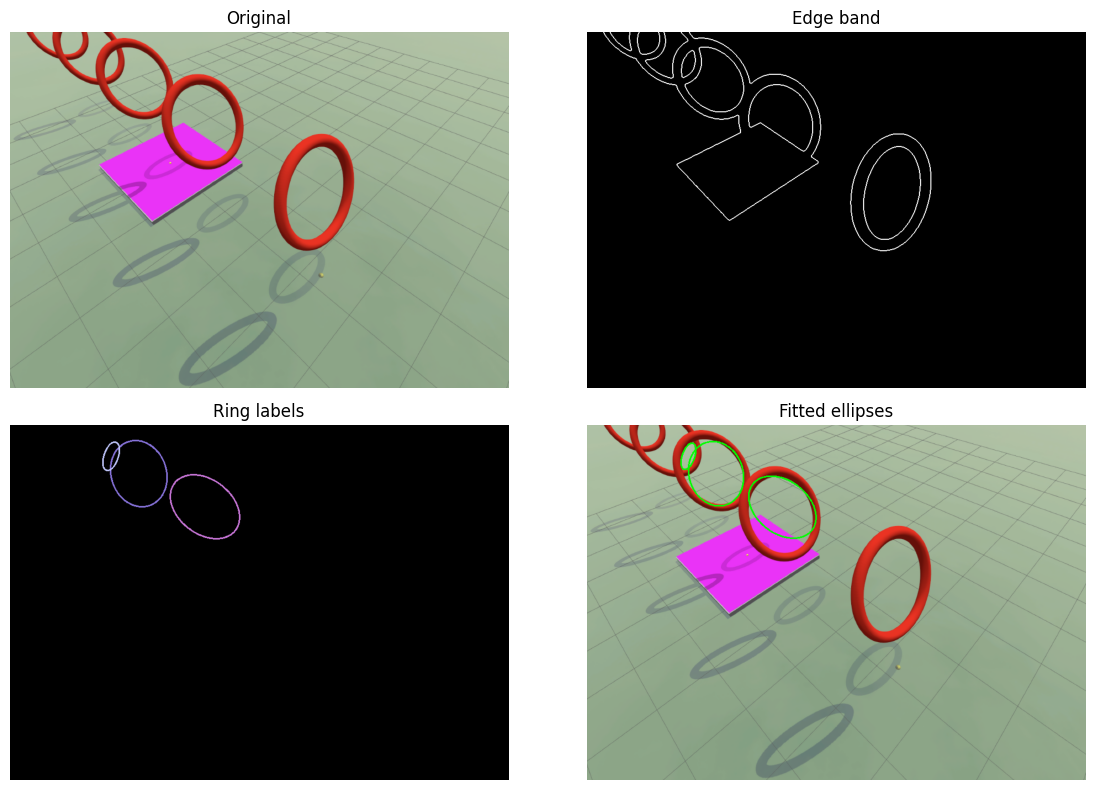

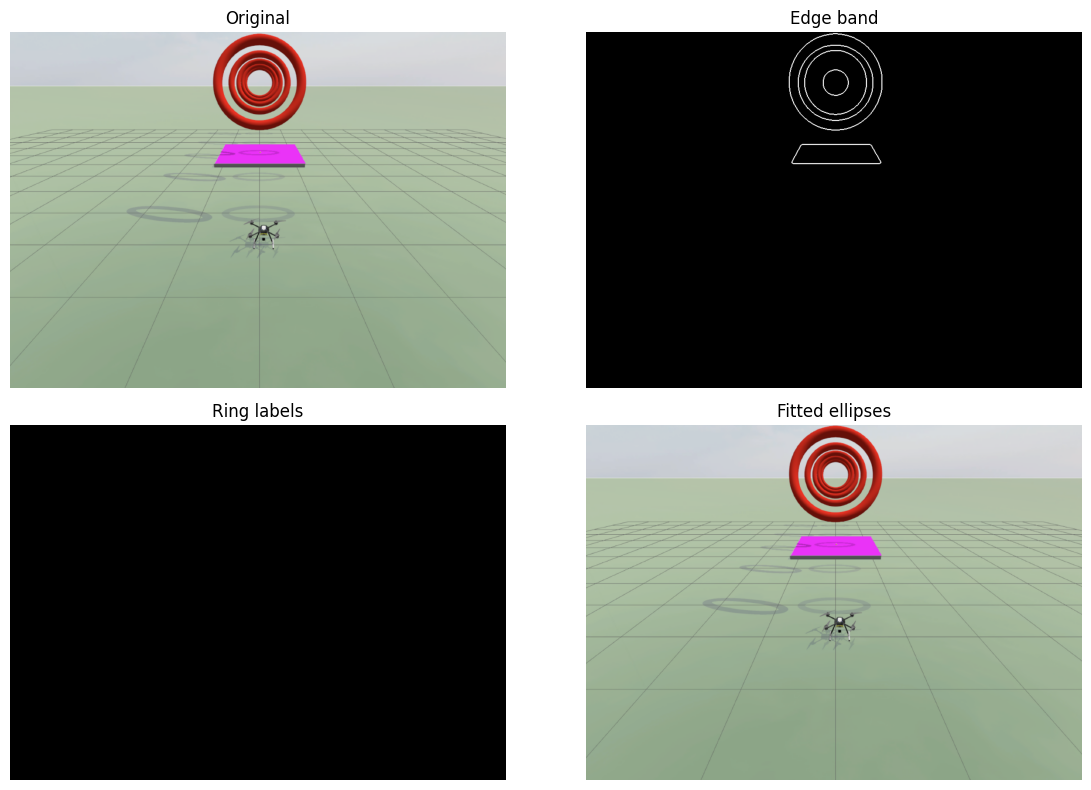

In [4]:
# Step 2 (new): detect multiple rings from mask edges, validate with elliptical-band coverage

all_ellipses_per_image = []
all_seg_debug_images = []

def draw_ellipse_rgb(img_rgb, ellipse, color=(0,255,0), thickness=2):
    bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR).copy()
    cv2.ellipse(bgr, ellipse, color, thickness)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def ellipse_band_mask(shape, ellipse, band_px=6):
    # Draw a thin elliptical band by rasterizing two ellipses and subtracting
    mask_outer = np.zeros(shape, dtype=np.uint8)
    mask_inner = np.zeros(shape, dtype=np.uint8)
    (cx, cy), (MA, ma), ang = ellipse
    # Thickness is clamped by band_px
    cv2.ellipse(mask_outer, (int(cx), int(cy)), (int(MA/2), int(ma/2)), ang, 0, 360, 255, thickness=band_px)
    # Slightly smaller inner to form a band (avoid double edges overlap)
    shrink = max(1, band_px//2)
    cv2.ellipse(mask_inner, (int(cx), int(cy)), (max(1,int(MA/2)-shrink), max(1,int(ma/2)-shrink)), ang, 0, 360, 255, thickness=band_px)
    band = cv2.bitwise_and(mask_outer, cv2.bitwise_not(mask_inner))
    return band

def iou_like(e1, e2):
    # Fast de-duplication proxy: compare centers and axes similarity
    (c1x, c1y), (MA1, ma1), a1 = e1
    (c2x, c2y), (MA2, ma2), a2 = e2
    dc = np.hypot(c1x-c2x, c1y-c2y)
    s1 = 0.5*(MA1+ma1); s2 = 0.5*(MA2+ma2)
    s = 0.5*(s1+s2)
    angdiff = min(abs(a1-a2), 180-abs(a1-a2))
    # Treat as duplicate if centers very close and sizes and angles similar
    return (dc < 0.05*s) and (abs(MA1-MA2) < 0.08*s) and (abs(ma1-ma2) < 0.08*s) and (angdiff < 8.0)

for idx, D in enumerate(all_step1_debug):
    rgb = D['rgb']
    mask = D['mask_refined']
    h, w = mask.shape[:2]

    # 1) Thin edge band to isolate rims (morphological gradient)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    edge_band = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, k)

    # 2) Contours on the edge band only
    contours, _ = cv2.findContours(edge_band, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # 3) Fit ellipses to each rim-like contour
    cands = []
    for cnt in contours:
        if len(cnt) < 40:   # need enough points for a stable ellipse
            continue
        area = cv2.contourArea(cnt)
        per  = cv2.arcLength(cnt, True)
        if per <= 1e-3:
            continue
        # Basic rim shape heuristic: prefer roundish contours
        circularity = 4*np.pi*area/(per*per)
        if circularity < 0.4:  # allow tilted ellipses but reject rectangles/strips
            continue
        # Robust ellipse fit
        try:
            e = cv2.fitEllipseAMS(cnt)
        except Exception:
            try:
                e = cv2.fitEllipse(cnt)
            except Exception:
                continue
        (cx, cy), (MA, ma), ang = e
        # Axis sanity
        if MA < 12 or ma < 12:  # very tiny
            continue
        # Aspect ratio within a reasonable ellipse range
        ar = min(MA,ma) / max(MA,ma)
        if ar < 0.15:  # extremely skinny -> likely plate edge, not ring
            continue
        cands.append(e)

    # 4) Validate each ellipse by measuring how much of an elliptical band overlaps mask foreground
    accepted = []
    for e in cands:
        band = ellipse_band_mask((h,w), e, band_px=6)
        # Coverage: ring pixels present within the band
        overlap = cv2.bitwise_and(band, mask)
        cov = (overlap > 0).sum() / max((band > 0).sum(), 1)
        if cov < 0.55:
            continue
        # Reject if the band extends far outside mask (low precision)
        prec = (overlap > 0).sum() / max((mask > 0).sum(), 1)
        # Keep moderate precision; main gate is cov
        accepted.append(e)

    # 5) Non-maximum suppression to deduplicate near-identical fits
    final_ellipses = []
    for e in sorted(accepted, key=lambda x: max(x[1][0], x[1][1]), reverse=True):
        if any(iou_like(e, f) for f in final_ellipses):
            continue
        final_ellipses.append(e)

    # 6) Prepare outputs compatible with downstream code
    ellipses = []
    overlay = rgb.copy()
    label_img = np.zeros((h,w,3), dtype=np.uint8)
    rng = np.random.default_rng(12345)

    for lab, e in enumerate(final_ellipses, start=2):
        ellipses.append((lab, e))
        overlay = draw_ellipse_rgb(overlay, e, color=(0,255,0), thickness=2)
        color = tuple(map(int, rng.integers(80, 255, size=3)))
        band = ellipse_band_mask((h,w), e, band_px=6)
        label_img[band > 0] = color

    # 7) Distance transform (debug panel kept for interface parity)
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

    all_ellipses_per_image.append(ellipses)
    all_seg_debug_images.append((label_img, overlay, dist_norm))

    show_grid(
        [rgb, edge_band, label_img, overlay],
        titles=["Original", "Edge band", "Ring labels", "Fitted ellipses"],
        ncols=2
    )


Image 1: 3 ellipse candidates
  Label 2: center=(359.8,152.8), axes=(96.8,138.2), angle=128.1 deg
  Conic matrix:
 [[ 2.92167510e-04 -1.05502587e-04 -8.89963594e-02]
 [-1.05502587e-04  3.43610432e-04 -1.45386894e-02]
 [-8.89963594e-02 -1.45386894e-02  3.32399180e+01]]
  Label 3: center=(237.5,91.1), axes=(99.6,120.6), angle=162.0 deg
  Conic matrix:
 [[ 3.91023166e-04 -3.75414121e-05 -8.94404308e-02]
 [-3.75414121e-05  2.87360864e-04 -1.72700741e-02]
 [-8.94404308e-02 -1.72700741e-02  2.18143046e+01]]
  Label 4: center=(186.6,59.0), axes=(23.1,51.0), angle=198.6 deg
  Conic matrix:
 [[ 6.87887882e-03  1.80131260e-03 -1.38972710e+00]
 [ 1.80131260e-03  2.14811404e-03 -4.62834266e-01]
 [-1.38972710e+00 -4.62834266e-01  2.85600741e+02]]


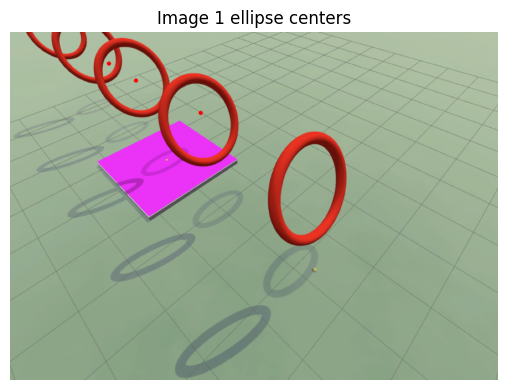

Image 2: 0 ellipse candidates


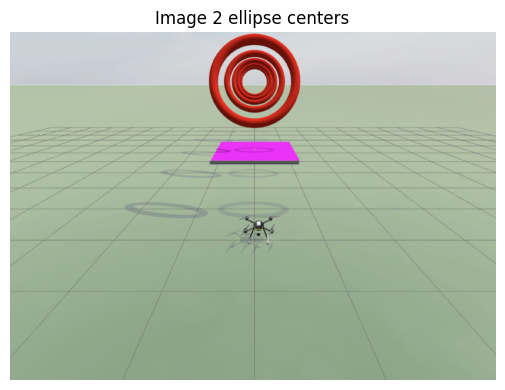

In [5]:
for idx, ellipses in enumerate(all_ellipses_per_image):
    rgb = all_step1_debug[idx]['rgb'].copy()
    centers = []
    print(f"Image {idx+1}: {len(ellipses)} ellipse candidates")
    for lab, e in ellipses:
        (cx, cy), (MA, ma), angle = e
        centers.append((int(cx), int(cy)))
        cv2.circle(rgb, (int(cx), int(cy)), 4, (255, 0, 0), -1)
        # Conic matrix
        C = ellipse_conic_matrix((cx, cy), (MA, ma), angle)
        print(f"  Label {lab}: center=({cx:.1f},{cy:.1f}), axes=({MA:.1f},{ma:.1f}), angle={angle:.1f} deg")
        print("  Conic matrix:\n", C)
    show_grid([rgb], titles=[f"Image {idx+1} ellipse centers"], ncols=1)



Image 1 | K=
[[568.05269201   0.         460.        ]
 [  0.         568.05269201 328.        ]
 [  0.           0.           1.        ]]
Quaternion (w,x,y,z)=(1.0, 0.0, 0.0, 0.0)


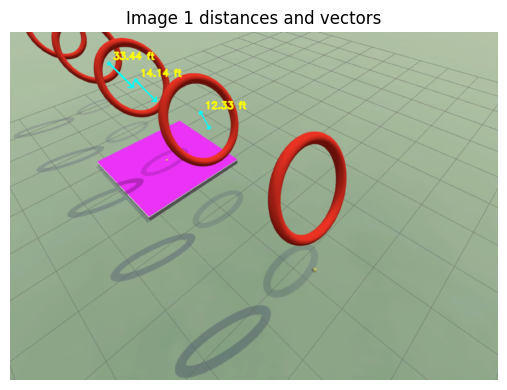


Image 2 | K=
[[575.46207495   0.         466.        ]
 [  0.         575.46207495 334.        ]
 [  0.           0.           1.        ]]
Quaternion (w,x,y,z)=(1.0, 0.0, 0.0, 0.0)


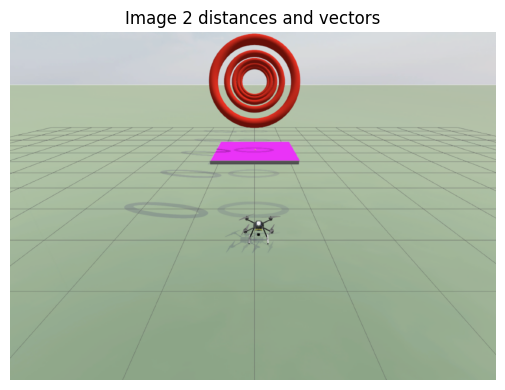

In [6]:
RING_DIAM_FT = 3.0
RING_RAD_FT = RING_DIAM_FT / 2.0

for idx, ellipses in enumerate(all_ellipses_per_image):
    rgb = all_step1_debug[idx]['rgb'].copy()
    h, w = rgb.shape[:2]
    # Nominal intrinsics
    K = estimate_K_from_fov(w, h, hfov_deg=78.0)
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
    # Baseline camera quaternion (identity)
    q_cam = (1.0, 0.0, 0.0, 0.0)
    R_cam = quat_to_R(*q_cam)  # unused here, but kept for extension

    print(f"\nImage {idx+1} | K=\n{K}\nQuaternion (w,x,y,z)={q_cam}")

    rgb_overlay = rgb.copy()

    centers_3d = []
    normals_3d = []

    for lab, e in ellipses:
        (u, v), (MA, ma), angle = e
        a_px = max(MA, ma) / 2.0
        b_px = min(MA, ma) / 2.0

        z_ft = estimate_distance_from_ellipse(a_px, RING_RAD_FT, fx)
        if z_ft is None:
            continue

        # 3D center in camera frame (approx)
        X_ft = (u - cx) * z_ft / fx
        Y_ft = (v - cy) * z_ft / fy
        Z_ft = z_ft
        centers_3d.append((X_ft, Y_ft, Z_ft))

        # Approximate tilt from b/a, and normal direction along ellipse minor axis
        tilt = np.arccos(np.clip(b_px / max(a_px, 1e-6), 0.0, 1.0))
        theta = np.deg2rad(angle)
        # Minor axis direction in image
        vmin_img = np.array([ -np.sin(theta),  np.cos(theta) ])  # unit vector
        # Lift to 3D approx: scale xy by sin(tilt), z by cos(tilt)
        nx = (vmin_img[0] / fx) * np.sin(tilt)
        ny = (vmin_img[1] / fy) * np.sin(tilt)
        nz = np.cos(tilt)
        nvec = np.array([nx, ny, nz], dtype=np.float64)
        nvec /= (np.linalg.norm(nvec) + 1e-9)
        normals_3d.append(nvec.tolist())

        # Label on image with distance
        cv2.putText(rgb_overlay, f"{z_ft:.2f} ft", (int(u)+8, int(v)-8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2, cv2.LINE_AA)

        # Draw outward vector projected to image
        # pick a 3D endpoint at center + L * n
        L_ft = max(1.0, 0.2 * z_ft)
        P0 = np.array([X_ft, Y_ft, Z_ft])
        P1 = P0 + L_ft * nvec
        # Project to image
        def project_point(P):
            X, Y, Z = P
            if Z <= 1e-3: Z = 1e-3
            u_proj = fx * (X / Z) + cx
            v_proj = fy * (Y / Z) + cy
            return int(round(u_proj)), int(round(v_proj))
        p0 = project_point(P0)
        p1 = project_point(P1)
        cv2.circle(rgb_overlay, (int(u), int(v)), 4, (0,255,255), -1)
        cv2.arrowedLine(rgb_overlay, p0, p1, (0,255,255), 2, tipLength=0.15)

    show_grid([rgb_overlay], titles=[f"Image {idx+1} distances and vectors"], ncols=1)


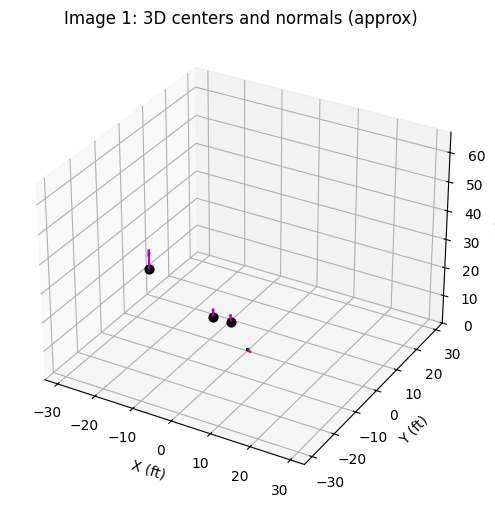

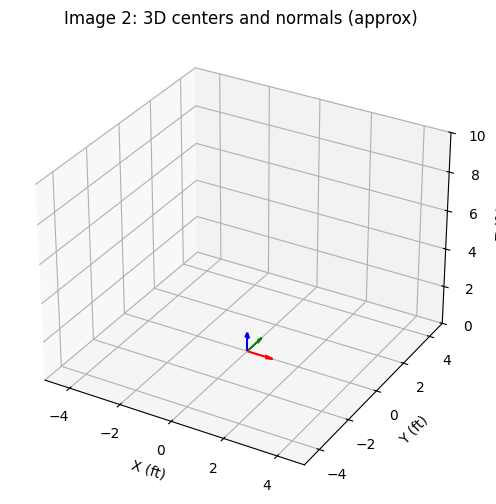

In [7]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

for idx, ellipses in enumerate(all_ellipses_per_image):
    # Recompute centers/normals as above to plot
    rgb = all_step1_debug[idx]['rgb'].copy()
    h, w = rgb.shape[:2]
    K = estimate_K_from_fov(w, h, hfov_deg=78.0)
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]

    centers_3d = []
    normals_3d = []

    for lab, e in ellipses:
        (u, v), (MA, ma), angle = e
        a_px = max(MA, ma) / 2.0
        b_px = min(MA, ma) / 2.0
        z_ft = estimate_distance_from_ellipse(a_px, RING_RAD_FT, fx)
        if z_ft is None:
            continue
        X_ft = (u - cx) * z_ft / fx
        Y_ft = (v - cy) * z_ft / fy
        Z_ft = z_ft
        centers_3d.append((X_ft, Y_ft, Z_ft))

        tilt = np.arccos(np.clip(b_px / max(a_px, 1e-6), 0.0, 1.0))
        theta = np.deg2rad(angle)
        vmin_img = np.array([ -np.sin(theta),  np.cos(theta) ])
        nx = (vmin_img[0] / fx) * np.sin(tilt)
        ny = (vmin_img[1] / fy) * np.sin(tilt)
        nz = np.cos(tilt)
        nvec = np.array([nx, ny, nz], dtype=np.float64)
        nvec /= (np.linalg.norm(nvec) + 1e-9)
        normals_3d.append(nvec.tolist())

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(0,0,0,  1,0,0, length=1, color='r')
    ax.quiver(0,0,0,  0,1,0, length=1, color='g')
    ax.quiver(0,0,0,  0,0,1, length=1, color='b')
    for (X,Y,Z), nvec in zip(centers_3d, normals_3d):
        ax.scatter([X],[Y],[Z], c='k', s=40)
        ax.quiver(X,Y,Z, nvec[0],nvec[1],nvec[2], length=max(1.0, 0.2*Z), color='m')
    ax.set_xlabel('X (ft)'); ax.set_ylabel('Y (ft)'); ax.set_zlabel('Z (ft)')
    ax.set_title(f"Image {idx+1}: 3D centers and normals (approx)")
    # Set equal-ish aspect
    lim =  max([abs(c) for C in centers_3d for c in C] + [5])
    ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_zlim(0, 2*lim)
    plt.show()
